## Useful sources: 
- https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312
- https://github.com/marcosan93/Price-Forecaster
- https://technical-analysis-library-in-python.readthedocs.io/en/latest/
- https://towardsdatascience.com/technical-indicators-on-bitcoin-using-python-c392b4a33810

In [3]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

In [67]:
import keras

In future, to add features, TA (Technical analysis) library can be used:
https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312

In [68]:
#https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312
#Technical Analysis Library
import ta

ModuleNotFoundError: No module named 'ta'

In [12]:
#Neural Networks libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.
C:\Users\Darek_PC\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Darek_PC\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Darek_PC\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Darek_PC\anaconda3\lib\site-packages\tensorflow\python\framewo

## Load data and prepare it to further usage

In [15]:
df = pd.read_csv('FINALDATAdaily.csv', 
                 index_col='timestamp',                  
                 dtype={'price': 'float64'})
df.index = pd.to_datetime(df.index)
df.sort_index(axis=0, inplace=True)
df

,price
timestamp,
2008-10-27,543.571429
2008-10-28,816.965172
2008-10-29,715.000000
2008-10-30,715.500000
2008-10-31,716.000000
...,...
2021-07-25,328.054631
2021-07-26,328.521387
2021-07-27,330.556857


## Preprocess data - normalize and scale it

In [16]:
scaler = RobustScaler()

scaler.fit_transform(df)

array([[5.40596401],
       [9.38596922],
       [7.90158296],
       ...,
       [2.30494534],
       [2.29442506],
       [2.38877819]])

In [28]:
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df

,price
timestamp,
2008-10-27,5.405964
2008-10-28,9.385969
2008-10-29,7.901583
2008-10-30,7.908862
2008-10-31,7.916141
...,...
2021-07-25,2.268518
2021-07-26,2.275313
2021-07-27,2.304945


In [90]:
# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()
close_scaler.fit(df[['price']])

RobustScaler()

## Functions to be used

In [107]:
def val_mse(df1, df2):
    #calculate mean square error between two dataframes
    df = df1.copy() #??? WHY TO CREATE A COPY?
    df['price2'] = df2.price #add new column with the price from the second dataframe
    df['diff'] = df.price - df.price2 #add new column with difference between prices
    mse = (df[['diff']] ** 2).mean() #calculate MSE
    return mse

In [58]:
def split_sequence(sequence, n_steps_in, n_steps_out, window):
    X, y = [], [] #list for both variables
    for i in range(0, len(seq), window):
        # Finding the end of the current sequence
        end = i + n_steps_in
        #The end of period to predict
        out_end = end + n_steps_out

        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break

        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [81]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [103]:
def validater(n_in, n_out):
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])
    
    for i in range(n_in, len(df)-n_in, n_out):
        x = df[-i - n_in: -i] ##?? Co to za konstrukcja?
        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses every days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="D"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions

In [100]:
x = df[-i - n_in: -i]
x

,price
timestamp,
2008-11-05,4.637050
2008-11-06,5.025938
2008-11-07,5.016313
2008-11-08,5.006689
2008-11-09,4.997064
...,...
2009-01-29,2.397099
2009-01-30,2.409074
2009-01-31,2.421049


In [98]:
pd.DataFrame(index=df.index, columns=[df.columns[0]])

,price
timestamp,
2008-10-27,NaN
2008-10-28,NaN
2008-10-29,NaN
2008-10-30,NaN
2008-10-31,NaN
...,...
2021-07-25,NaN
2021-07-26,NaN
2021-07-27,NaN


## SANDBOX

In [44]:
seq[end:out_end, 0]

array([2.31444337, 2.32878761, 2.30245482, 2.27612203, 2.24978924,
       2.22345645, 2.22776926, 2.07465582, 2.33076077, 2.37423522,
       2.41770967, 2.46118412, 2.41896248, 2.45423705, 2.37237894,
       2.33336566, 2.27078243, 2.2081992 , 2.14561597, 2.19529257,
       2.35449502, 2.32340757, 2.25492863, 2.26172356, 2.26851849,
       2.27531342, 2.30494534, 2.29442506, 2.38877819])

In [51]:
seq = df.to_numpy()
n_steps_in = 90
n_steps_out = 30
#WINDOW (HOW MANY TO SHIFT)
window = 30

# Creating a list for both variables
X, y = [], []

for i in range(0, len(seq), window):
    # Finding the end of the current sequence
    end = i + n_steps_in
    #The end of period to predict
    out_end = end + n_steps_out
    
    # Breaking out of the loop if we have exceeded the dataset's length
    if out_end > len(seq):
        break

    # Splitting the sequences into: x = past prices and indicators, y = prices ahead
    seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
    #print(seq_x)
    #print(seq_y)

    X.append(seq_x)
    y.append(seq_y)

np.array(X), np.array(y)

(array([[[5.40596401],
         [9.38596922],
         [7.90158296],
         ...,
         [2.39348345],
         [2.39209027],
         [2.3906971 ]],
 
        [[3.15574759],
         [2.96649649],
         [2.77724539],
         ...,
         [1.74655476],
         [1.76402409],
         [1.78149343]],
 
        [[2.58658546],
         [2.57977618],
         [2.5729669 ],
         ...,
         [2.27063474],
         [2.28810407],
         [2.3055734 ]],
 
        ...,
 
        [[0.67767438],
         [0.64624452],
         [0.61481467],
         ...,
         [2.58741081],
         [2.48891287],
         [2.4197145 ]],
 
        [[0.87909973],
         [0.89465884],
         [0.85861638],
         ...,
         [2.20356419],
         [2.2955617 ],
         [2.35708076]],
 
        [[2.80103353],
         [2.48031387],
         [2.26520448],
         ...,
         [2.43631969],
         [2.48931298],
         [2.54230628]]]),
 array([[2.38930392, 2.38791074, 2.38651756, ..., 1.746

In [19]:
df.shape[1]

1

In [29]:
df.to_numpy()

array([[5.40596401],
       [9.38596922],
       [7.90158296],
       ...,
       [2.30494534],
       [2.29442506],
       [2.38877819]])

## Splitting the data

In [66]:
#TODO
#random_state = 7 #(zawsze ta sama, stała wartość)
#Przy normalizacji danych - zapamiętuj std i mean

In [64]:
#HOW MANY PERIODS TO LOOK BACK TO LEARN
n_in = 90

#HOW MANY PERIODS TO PREDICT
n_out = 30

#WINDOW (HOW MANY TO SHIFT)
window = 30

#NUMBER OF FEATURES
n_features = df.shape[1]

#SPLIT DATA INTO X and y
X, y = split_sequence(df.to_numpy(), n_in, n_out, window)

## Neural Network Modelling

In [75]:
model = Sequential() #initialize the model
#'tanh' is probably not good activation function
activ_func = 'softsign' #later: CHANGE to 'softsign' (DON'T MIX WITH 'softmax')

#input layer
model.add(LSTM(60, 
               activation=activ_func, 
               return_sequences=True, 
               input_shape=(n_in, n_features)))
#hidden layer
model.add(LSTM(30,
              activation=activ_func))
#output layer
model.add(Dense(n_out))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 90, 60)            14880     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
Total params: 26,730
Trainable params: 26,730
Non-trainable params: 0
_________________________________________________________________


In [76]:
#optimizer='adam' can be also tried. RMSProp, AdaGrad or momentum(Nesterovs) are suggested
model.compile(optimizer='adagrad', loss='mse', metrics=['accuracy']) 

In [86]:
results = model.fit(X, y, epochs=10, batch_size = 32, validation_split=0.1)

Train on 136 samples, validate on 16 samples
Epoch 1/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0440 - accuracy: 0.0368 - val_loss: 0.1697 - val_accuracy: 0.0000e+00
Epoch 2/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0443 - accuracy: 0.0368 - val_loss: 0.1632 - val_accuracy: 0.0000e+00
Epoch 3/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.0368 - val_loss: 0.1613 - val_accuracy: 0.0000e+00
Epoch 4/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0429 - accuracy: 0.0294 - val_loss: 0.1538 - val_accuracy: 0.0000e+00
Epoch 5/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0426 - accuracy: 0.0294 - val_loss: 0.1392 - val_accuracy: 0.0000e+00
Epoch 6/10
136/136 [==============================] - 1s 5ms/step - loss: 0.0437 - accuracy: 0.0221 - val_loss: 0.1512 - val_accuracy: 0.0000e+00
Epoch 7/10
136/136 [==============================] - 1s 5ms/step - loss: 0.042

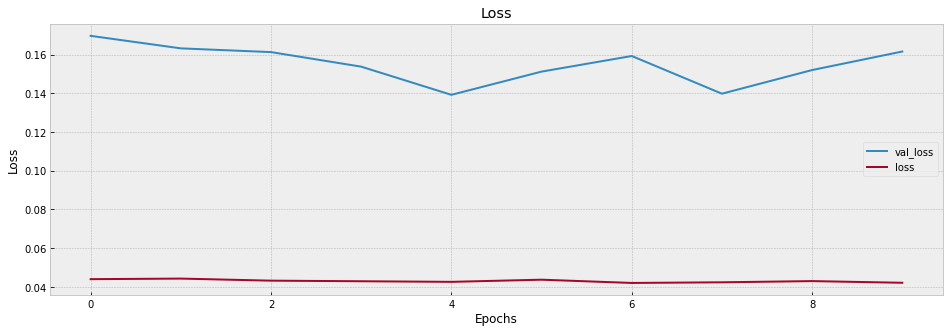

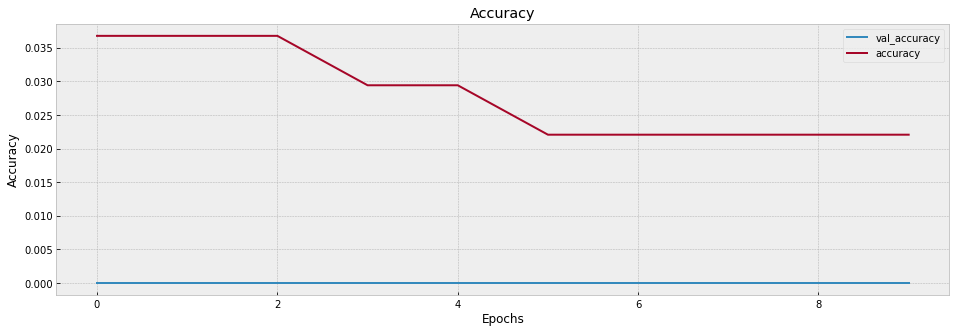

In [87]:
visualize_training_results(results)

## Model validation

In [88]:
df.price

timestamp
2008-10-27    5.405964
2008-10-28    9.385969
2008-10-29    7.901583
2008-10-30    7.908862
2008-10-31    7.916141
                ...   
2021-07-25    2.268518
2021-07-26    2.275313
2021-07-27    2.304945
2021-07-28    2.294425
2021-07-29    2.388778
Name: price, Length: 4659, dtype: float64

In [96]:
actual = pd.DataFrame(close_scaler.inverse_transform(df[["price"]]), index=df.index, columns=[df.columns[0]])

In [104]:
predictions = validater(n_in, n_out)

MSE: diff    0.068046
dtype: float64


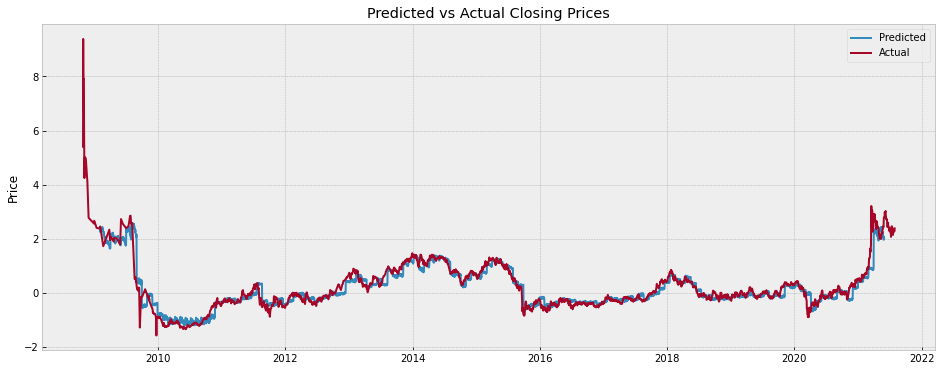

In [110]:
print('MSE:', val_mse(actual, predictions))

plt.figure(figsize=(16,6))
plt.plot(predictions, label='Predicted')
# Plotting the actual values
plt.plot(actual, label='Actual')
plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('2018-05', '2020-05')
plt.show()

## Forecast the future

               price
2021-07-30  2.315512
2021-07-31  2.194742
2021-08-01  2.253883
2021-08-02  2.287284
2021-08-03  2.181378
2021-08-04  2.189598
2021-08-05  2.305377
2021-08-06  2.246824
2021-08-07  2.314730
2021-08-08  2.255015
2021-08-09  2.297852
2021-08-10  2.334957
2021-08-11  2.268214
2021-08-12  2.357438
2021-08-13  2.238517
2021-08-14  2.235521
2021-08-15  2.275912
2021-08-16  2.234513
2021-08-17  2.202140
2021-08-18  2.193177
2021-08-19  2.174100
2021-08-20  2.098415
2021-08-21  2.175615
2021-08-22  2.063834
2021-08-23  2.026050
2021-08-24  2.001006
2021-08-25  2.002410
2021-08-26  1.926761
2021-08-27  2.003813
2021-08-28  1.968706


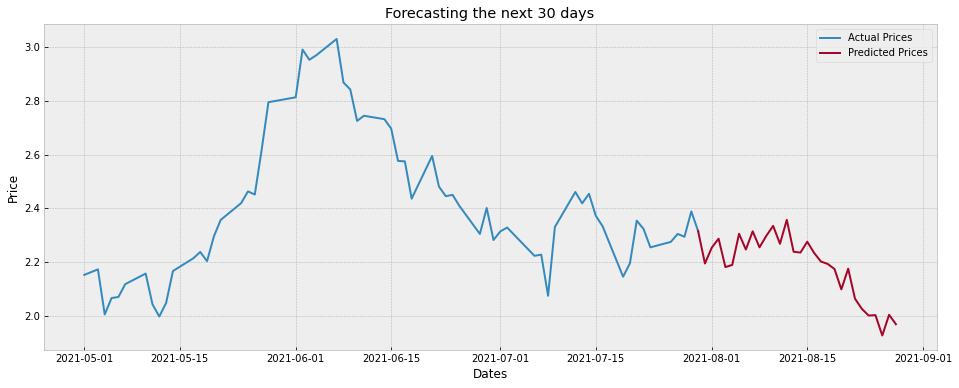

In [113]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_in)).reshape(1, n_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), #days=30?
                                         periods=len(yhat), 
                                         freq="D"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["price"]].tail(pers)), 
                      index=df.price.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()